In [17]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = WEB

train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

test = pd.read_csv(source + 'test_features.csv')

sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

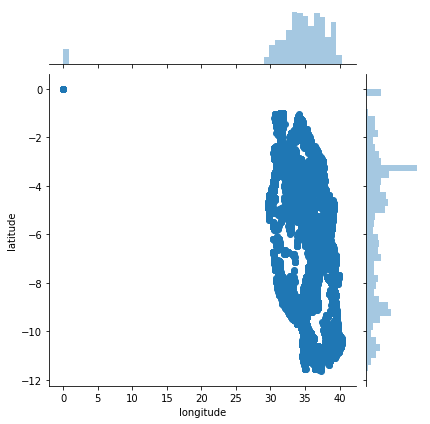

In [18]:
sns.jointplot(x='longitude', y='latitude', data=train);

In [19]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
#         X[col] = X[col].replace(0, X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

train['latitude'].max()

-0.99846435

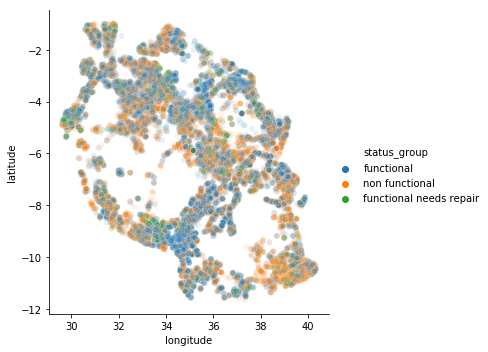

In [20]:
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

In [21]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [22]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.7279461279461279


In [23]:
len(X_train_encoded.columns)

181

In [24]:
len(model.coef_[0])

181

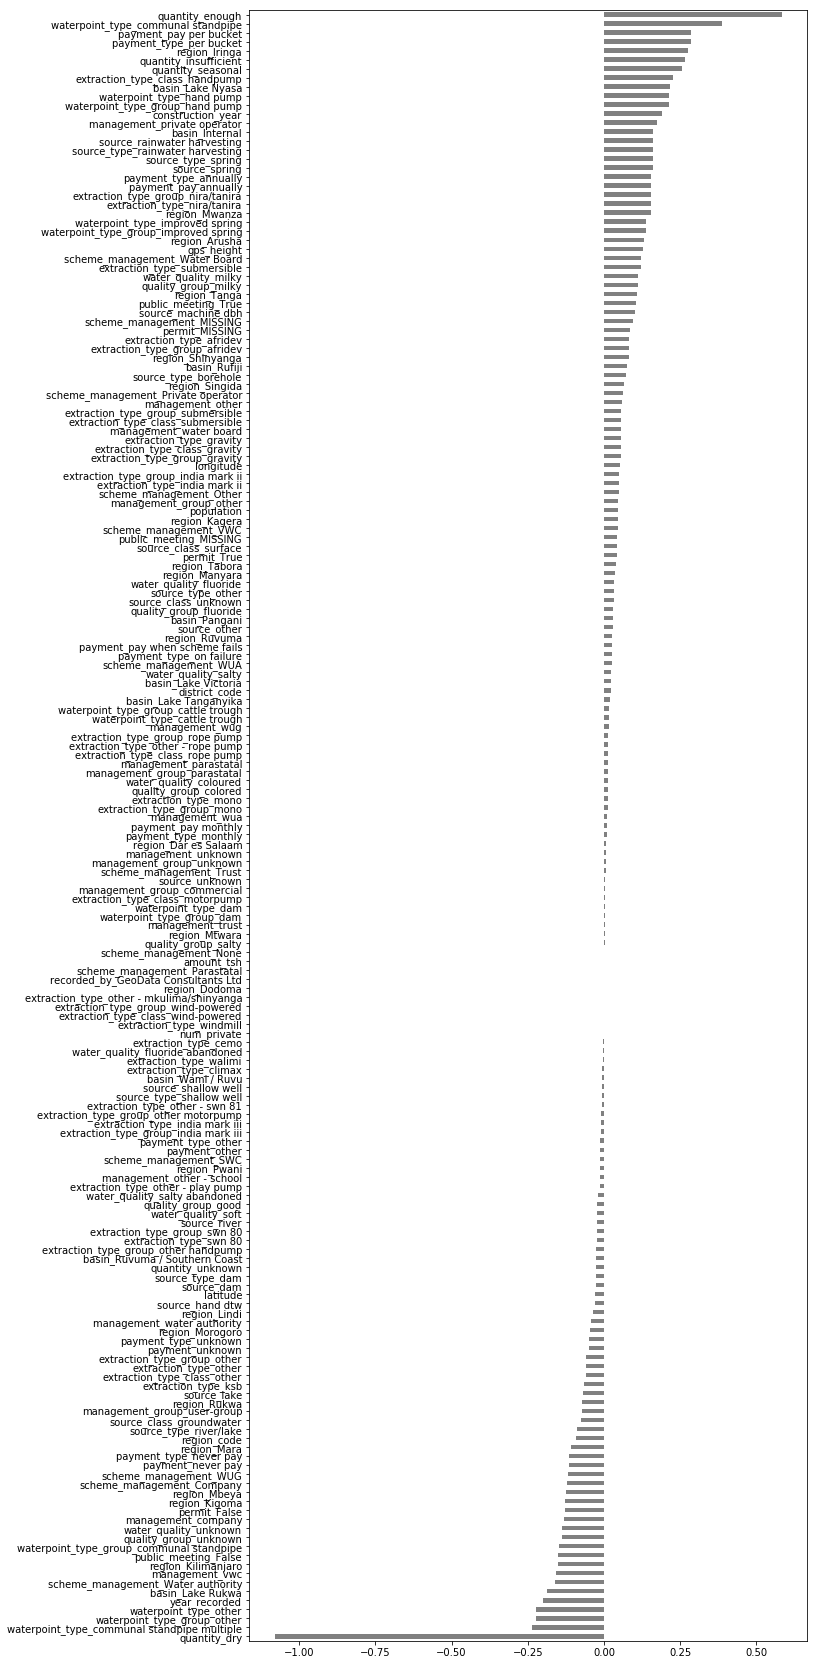

In [25]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [26]:
train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

lr = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.1, n_jobs=-1)
lr.fit(train_location, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
print('Logistic Regression Model')
print(f'Train Acc: {lr.score(train_location, y_train)}')
print(f'Val Acc: {lr.score(val_location, y_val)}')

Logistic Regression Model
Train Acc: 0.5430765993265994
Val Acc: 0.5430976430976431


In [28]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_location, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [29]:
print('Decision Tree Model')
print(f'Train Acc: {dt.score(train_location, y_train)}')
print(f'Val Acc: {dt.score(val_location, y_val)}')

Decision Tree Model
Train Acc: 0.984196127946128
Val Acc: 0.6301346801346801


In [30]:
max_dt_depth = 10

dt = DecisionTreeClassifier(max_depth=max_dt_depth,random_state=42)

dt.fit(train_location, y_train)

print(f'Decision Tree Model: Max Depth = {max_dt_depth}')
print(f'Train Acc: {dt.score(train_location, y_train)}')
print(f'Val Acc: {dt.score(val_location, y_val)}')

Decision Tree Model: Max Depth = 10
Train Acc: 0.6566498316498316
Val Acc: 0.6264309764309764


In [31]:
import graphviz
from sklearn.tree import export_graphviz


dot_data = export_graphviz(dt, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=train_location.columns,
                           class_names=dt.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rotate=True, 
                           rounded=True)   

graphviz.Source(dot_data)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

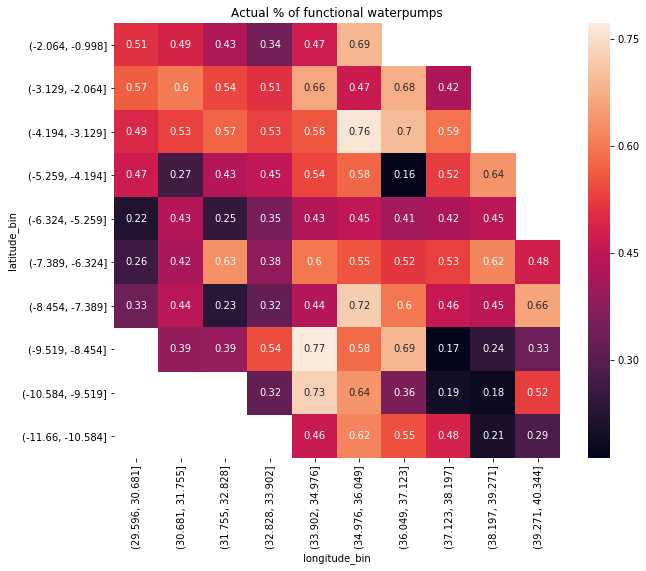

In [16]:
train_location['latitude_bin'] = pd.cut(train_location['latitude'], bins=10)
train_location['longitude_bin'] = pd.cut(train['longitude'], bins=10)
train_location['functional'] = (train['status_group'] == 'functional').astype(int)
table = train_location.pivot_table('functional', 'latitude_bin', 'longitude_bin')
plt.figure(figsize=(10,8))
plt.title('Actual % of functional waterpumps')
sns.heatmap(table[::-1], annot=True); # [::-1] reverses the table's rows so Tanzania appears right-side up

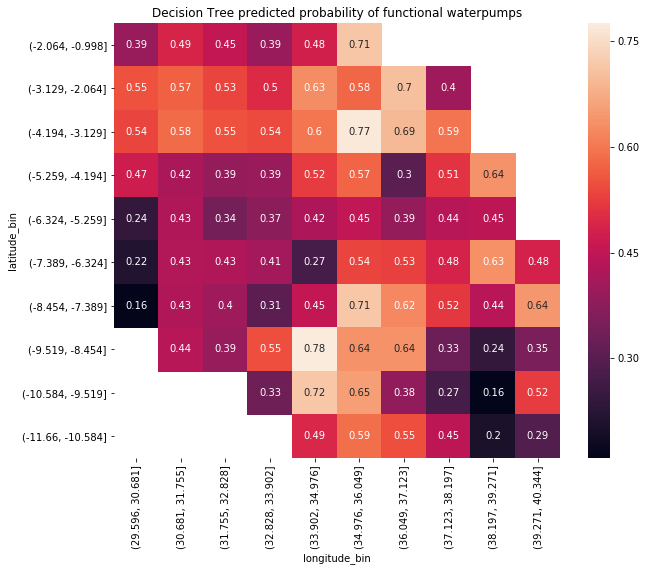

In [17]:
dt_pred_proba = dt.predict_proba(train_location[['longitude', 'latitude']])
train_location['dt_pred_proba_functional'] = dt_pred_proba[:,0]
table = train_location.pivot_table('dt_pred_proba_functional', 'latitude_bin', 'longitude_bin')
plt.figure(figsize=(10,8))
plt.title('Decision Tree predicted probability of functional waterpumps')
sns.heatmap(table[::-1], annot=True);

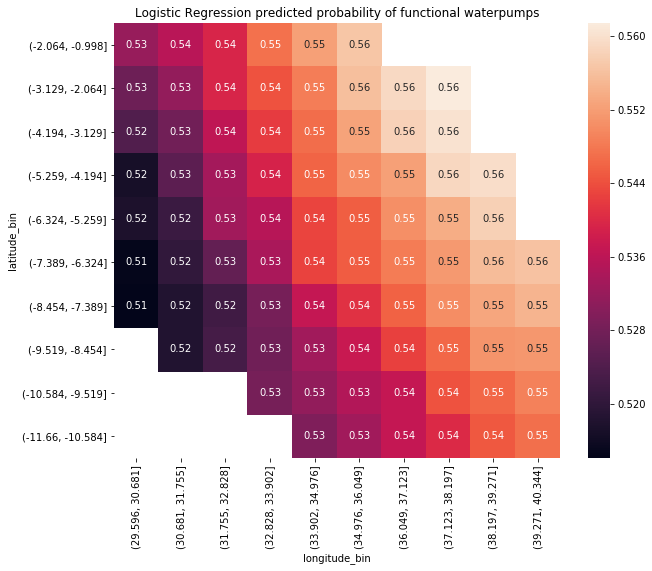

In [18]:
lr_pred_proba = lr.predict_proba(train_location[['longitude', 'latitude']])
train_location['lr_pred_proba_functional'] = lr_pred_proba[:,0]
table = train_location.pivot_table('lr_pred_proba_functional', 'latitude_bin', 'longitude_bin')
plt.figure(figsize=(10,8))
plt.title('Logistic Regression predicted probability of functional waterpumps')
sns.heatmap(table[::-1], annot=True);

In [19]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [20]:
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def viz3D(fitted_model, X, features, target='', class_index=0, num=100):
    """
    Visualize the predicted probabilities of a classifier, fit with two features.
    
    fitted_model : scikit-learn classifier 
    X : pandas dataframe the model was fitted on
    features : list of strings, the 2 features in the dataframe
    target : string, name of the target, to use for z axis title
    class_index: integer, index number of the class being predicted
    num : integer, how many gridpoints to use for the predictions
    """
    
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(min2, max2, num)
    combos = list(itertools.product(x1, x2))
    Z = fitted_model.predict_proba(combos)[:,class_index].reshape(num, num)

    configure_plotly_browser_state()
    data = [go.Surface(x=x1, y=x2, z=Z)]
    layout = go.Layout(
        scene={'xaxis': {'title': feature1, 'range': [min1,max1], 'showticklabels': True}, 
               'yaxis': {'title': feature2, 'range': [min2,max2], 'showticklabels': True}, 
               'zaxis': {'title': target, 'showticklabels': True}}, 
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

ModuleNotFoundError: No module named 'plotly'